## Send MWA data to JSON format for training

In [11]:
import numpy as np
import yaml
import os
import glob
import json
from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [12]:
# Get data
dirpath = '/users/jmduchar/data/jmduchar/Research/mcgill25/ssins_data/'
reference_obs = '1093799552'  # known to contain RFI

In [13]:
with open(dirpath+'gridpoint_dict.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
all_obs = np.array(list(data.keys()))
reference_idx = np.where(all_obs == reference_obs)[0][0]

obsids = all_obs[reference_idx-2:reference_idx+13]
pointings = [data[i] for i in obsids]
obsids, pointings

# data = {k: v for k, v in data.items() if v == 0}

# obsids = list(data.keys())

# obsids

(array(['1093799312', '1093799432', '1093799552', '1093799680',
        '1093799800', '1093799920', '1093800040', '1093800168',
        '1093800288', '1093800408', '1093800528', '1093800648',
        '1093800776', '1093800896', '1093801016'], dtype='<U10'),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
cb = np.load('../data/coarse_bands_1D.npy')
ssins_list = []

for obsid in obsids:
    file = dirpath + f"tars/{obsid}_SSINS_data.h5"
    
    with h5py.File(file, "r") as hf:
        
        # Access the SSINS
        ssins_rep = hf['Data']['metric_array'][:][:,:,0]  # xx polarization
        
        # Remove CB
        ssins_rep = ssins_rep[:,np.invert(cb)]
        
        # Avg across DTV7
        ssins_rep = np.mean(ssins_rep[:,350:525], axis=1)

        # Remove inf
        ssins_rep = ssins_rep[~np.isinf(ssins_rep)]

        # Append to list
        ssins_list.append(ssins_rep)

In [15]:
ssins = np.asarray(ssins_list).flatten()

ssins.shape

(750,)

In [16]:
# SUBTRACT MEDIAN
ssins = ssins - np.median(ssins)

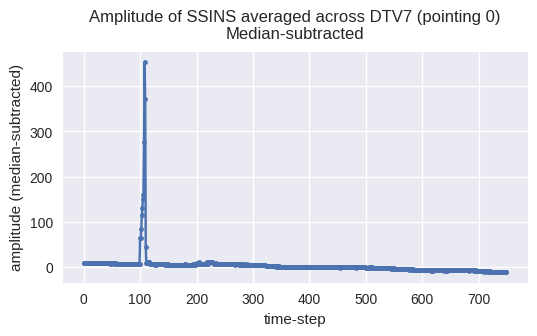

In [17]:
plt.figure(figsize=(6,3))
plt.plot(ssins, '.-')
plt.title("Amplitude of SSINS averaged across DTV7 (pointing 0)\nMedian-subtracted", y=1.02)
plt.xlabel("time-step")
plt.ylabel("amplitude (median-subtracted)")
# plt.yscale('log')
# plt.ylim(-1,1)
plt.savefig("./ssins_sample.png",dpi=300,bbox_inches='tight')
plt.show()

In [19]:
# Structure the data for Stan
stan_data = {
    "N": ssins.shape[0],
    "y": ssins.tolist(),
}

In [20]:
stan_data

{'N': 750,
 'y': [9.415425926497278,
  8.985410633681681,
  9.162825713356256,
  8.777291253749354,
  9.314885959070239,
  9.390995559141857,
  8.977618822432532,
  9.014576064430344,
  9.043611159075567,
  8.86910830978286,
  8.960426109344326,
  9.535258581114022,
  9.338589229402373,
  9.045094429517576,
  9.099310015303786,
  9.21168422101698,
  9.38348566540924,
  8.960864388675304,
  9.227161494520374,
  9.287341759365404,
  9.414312613654488,
  9.52549857607653,
  8.605524355820194,
  9.158243545035248,
  8.952020665852729,
  9.155999207640207,
  9.002506772627044,
  9.48704898279891,
  8.799123073913165,
  8.864243441023063,
  9.065714171514742,
  8.466395134766913,
  8.696520920937246,
  8.494386460486453,
  8.714795975564357,
  8.86503460842664,
  8.684662477747452,
  8.680729035594595,
  8.701859585857619,
  8.391226795796001,
  8.30301779976378,
  8.412358243419135,
  7.905321553922249,
  8.237968714641283,
  8.317867091304265,
  8.013424523513436,
  7.432118865744428,
  7.

In [21]:
# Write to JSON
with open("../data/three_state.data.json", "w") as f:
    json.dump(stan_data, f)